In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score
import lightgbm as lgb #Light Gradient Bossting Model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

%matplotlib inline

In [2]:
os.getcwd()

'C:\\Users\\91998\\AI_Genie_Capstone\\ML_Project'

In [3]:
os.chdir("D:\\Narendra\\AIGenie_Capstone_ALL")

In [4]:
os.listdir()

['AIGenie_Capstone_ALL.pptx',
 'dask-worker-space',
 'movie_metadata.csv',
 'sms.csv',
 'soccerball',
 'soccerball.zip']

In [5]:
import pandas as pd
movie_metadata = pd.read_csv('movie_metadata.csv')

In [6]:
#Taken from Kaggle Kernels
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object and df[col].dtype != 'datetime64':  # Exclude strings and Datetimes           
            # Print current column type
            #print("******************************")
            #print("Column: ",col)
            #print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            #print("min for this col: ",mn)
            #print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else: 
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            #print("dtype after: ",df[col].dtype)
            #print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",(100*mem_usg)/start_mem_usg,"% of the initial size")
    return df, NAlist

movie_metadata, NAlist = reduce_mem_usage(movie_metadata)

Memory usage of properties dataframe is : 1.077423095703125  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.7167196273803711  MB
This is  66.52165061606004 % of the initial size


In [7]:
movie_metadata.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723,178,0,855,Joel David Moore,1000,760505847,Action|Adventure|Fantasy|Sci-Fi,...,3054,English,USA,PG-13,237000000,2009,936,7.9,1.78,33000
1,Color,Gore Verbinski,302,169,563,1000,Orlando Bloom,40000,309404152,Action|Adventure|Fantasy,...,1238,English,USA,PG-13,300000000,2007,5000,7.1,2.35,0
2,Color,Sam Mendes,602,148,0,161,Rory Kinnear,11000,200074175,Action|Adventure|Thriller,...,994,English,UK,PG-13,245000000,2015,393,6.8,2.35,85000
3,Color,Christopher Nolan,813,164,22000,23000,Christian Bale,27000,448130642,Action|Thriller,...,2701,English,USA,PG-13,250000000,2012,23000,8.5,2.35,164000
4,NaN,Doug Walker,0,6,131,65535,Rob Walker,131,161,Documentary,...,0,NaN,NaN,NaN,217,1915,12,7.1,0.18,0


In [8]:
movie_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       5043 non-null uint16
duration                     5043 non-null uint16
director_facebook_likes      5043 non-null uint16
actor_3_facebook_likes       5043 non-null uint16
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5043 non-null uint32
gross                        5043 non-null uint32
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null uint32
cast_total_facebook_likes    5043 non-null uint32
actor_3_name                 5020 non-null object
facenumber_in_poster         5043 non-null uint8
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-null o

In [9]:
movie_metadata.drop(['aspect_ratio', 'movie_imdb_link'], axis= 1, inplace = True)

In [10]:
movie_metadata.isnull().sum()

color                         19
director_name                104
num_critic_for_reviews         0
duration                       0
director_facebook_likes        0
actor_3_facebook_likes         0
actor_2_name                  13
actor_1_facebook_likes         0
gross                          0
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster           0
plot_keywords                153
num_user_for_reviews           0
language                      12
country                        5
content_rating               303
budget                         0
title_year                     0
actor_2_facebook_likes         0
imdb_score                     0
movie_facebook_likes           0
dtype: int64

In [11]:
movie_metadata['color'].fillna('Color', inplace = True)
movie_metadata['director_name'].fillna('Unk', inplace = True)
movie_metadata['actor_2_name'].fillna('Unk', inplace = True)
movie_metadata['actor_1_name'].fillna('Unk', inplace = True)
movie_metadata['actor_3_name'].fillna('Unk', inplace = True)
movie_metadata['plot_keywords'].fillna('Unk', inplace = True)
movie_metadata['content_rating'].fillna('Un Rated', inplace = True)
movie_metadata['language'].fillna('Unk', inplace = True)
movie_metadata['country'].fillna('Unk', inplace = True)

In [12]:
movie_metadata.isnull().sum()

color                        0
director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
genres                       0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
plot_keywords                0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
movie_facebook_likes         0
dtype: int64

In [13]:
#Common Keywords in plot_keywords feature
plot_keywords_list=[]
for row in movie_metadata.plot_keywords.apply(lambda x: x.split('|')):
    for item in row:
        plot_keywords_list.append(item.strip())
plot_keywords_list = np.unique(np.array(plot_keywords_list, dtype = 'object'))
for a,b in zip(*np.unique(plot_keywords_list, return_counts=True)):
        if b>1:
            print(a)

In [14]:
movie_metadata.drop('plot_keywords', axis =1, inplace = True)

In [15]:
languages_list = []
for a,b in zip(*np.unique(movie_metadata['language'], return_counts = True)):
        if b>5 and a!='Unk':
            languages_list.append(a)
movie_metadata['cleaned_language'] = movie_metadata['language'].apply(lambda x:x if x in languages_list else 'other')
languages_list.append('other')

In [16]:
countries_list = []
for a,b in zip(*np.unique(movie_metadata['country'], return_counts = True)):
        if b>17 and a!='Unk':
            countries_list.append(a)
movie_metadata['cleaned_country'] = movie_metadata['country'].apply(lambda x:x if x in countries_list else 'other')
countries_list.append('other')

In [17]:
numeric_features = movie_metadata.columns[movie_metadata.dtypes!='object']
categorical_features = movie_metadata.columns[movie_metadata.dtypes=='object']
numeric_features, categorical_features

(Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
        'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
        'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
        'num_user_for_reviews', 'budget', 'title_year',
        'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes'],
       dtype='object'),
 Index(['color', 'director_name', 'actor_2_name', 'genres', 'actor_1_name',
        'movie_title', 'actor_3_name', 'language', 'country', 'content_rating',
        'cleaned_language', 'cleaned_country'],
       dtype='object'))

In [18]:
train_numeric_features = movie_metadata.columns[(movie_metadata.dtypes!='object') & (movie_metadata.columns!='imdb_score')]

In [19]:
for feature in train_numeric_features:
    movie_metadata[feature] = np.log1p(movie_metadata[feature])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015D797CB648>,
      dtype=object)

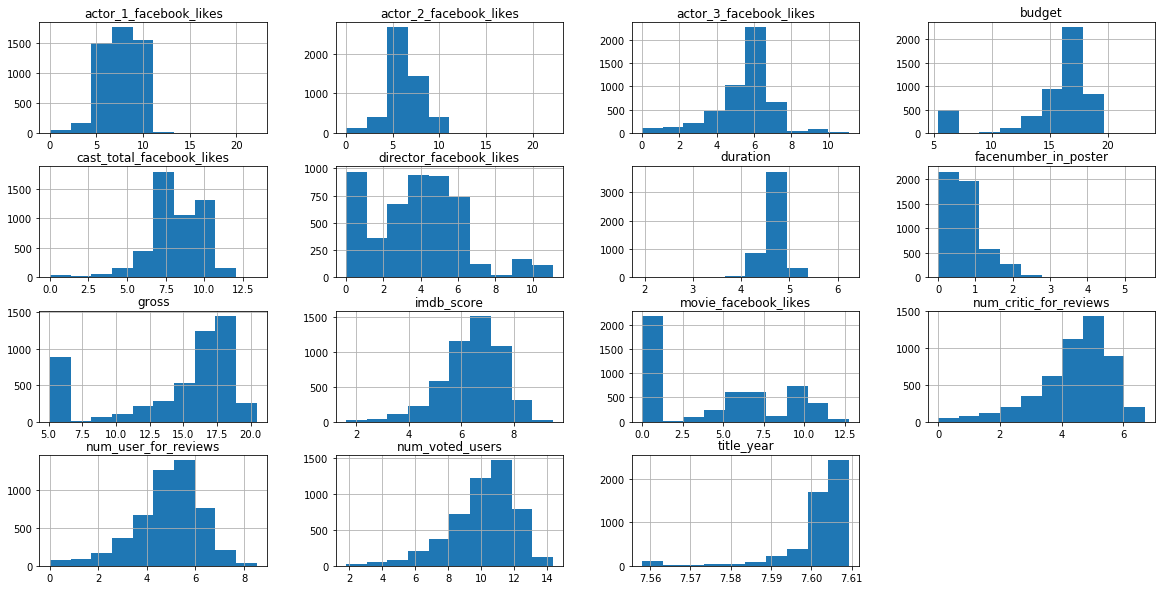

In [20]:
movie_metadata.hist(figsize = (20,10))

In [21]:
def split_data(data, cols):
    data_series = list(data.apply(lambda x: np.array([y.strip() for y in x.split('|')])))
    for i in range(len(data_series)):
        row_length = len(data_series[i])
        if row_length<cols:
            for col in range(cols-row_length):
                data_series[i] = np.append(data_series[i], 'N/A')
    return data_series
def expand_data(data, cols, _list):
    data_series = pd.Series(split_data(data, cols))
    temp = []
    for item in _list:
        temp.append(data_series.apply(lambda x: 1 if item in x else 0))
    return temp            

In [22]:
genres = movie_metadata.genres.apply(lambda x: len(x.split('|'))).max()
print("Max Number of Genres for each movie : ", genres)

Max Number of Genres for each movie :  8


In [23]:
genres_list=[]
for row in movie_metadata.genres.apply(lambda x: x.split('|')):
    for item in row:
        genres_list.append(item.strip())
genres_list = np.unique(np.array(genres_list, dtype = 'object'))
genres_list, genres_list.shape

(array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
        'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
        'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
        'Thriller', 'War', 'Western'], dtype=object), (26,))

In [24]:
movie_metadata[genres_list] = pd.DataFrame(np.array(expand_data(movie_metadata['genres'], genres, 
                                                               genres_list)).T, columns=genres_list)
movie_metadata[genres_list]

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5039,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
5040,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5041,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [25]:
feature_correlation = movie_metadata.corr()
feature_correlation.style.background_gradient(cmap='coolwarm')

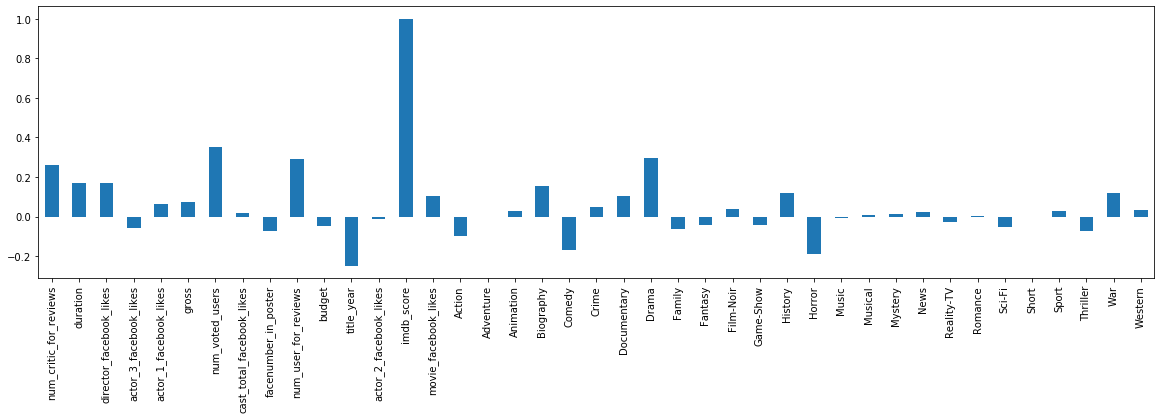

In [26]:
feature_correlation['imdb_score'].plot(kind='bar', figsize = (20,5))

In [27]:
movie_metadata.columns, len(movie_metadata.columns)

(Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
        'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
        'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
        'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
        'actor_3_name', 'facenumber_in_poster', 'num_user_for_reviews',
        'language', 'country', 'content_rating', 'budget', 'title_year',
        'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes',
        'cleaned_language', 'cleaned_country', 'Action', 'Adventure',
        'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
        'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror',
        'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance',
        'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western'],
       dtype='object'), 53)

In [28]:
movie_metadata.dtypes

color                         object
director_name                 object
num_critic_for_reviews       float32
duration                     float32
director_facebook_likes      float32
actor_3_facebook_likes       float32
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users              float64
cast_total_facebook_likes    float64
actor_3_name                  object
facenumber_in_poster         float16
num_user_for_reviews         float32
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float32
actor_2_facebook_likes       float64
imdb_score                   float32
movie_facebook_likes         float64
cleaned_language              object
cleaned_country               object
A

In [29]:
dataset_shape = movie_metadata.shape
dataset_shape

(5043, 53)

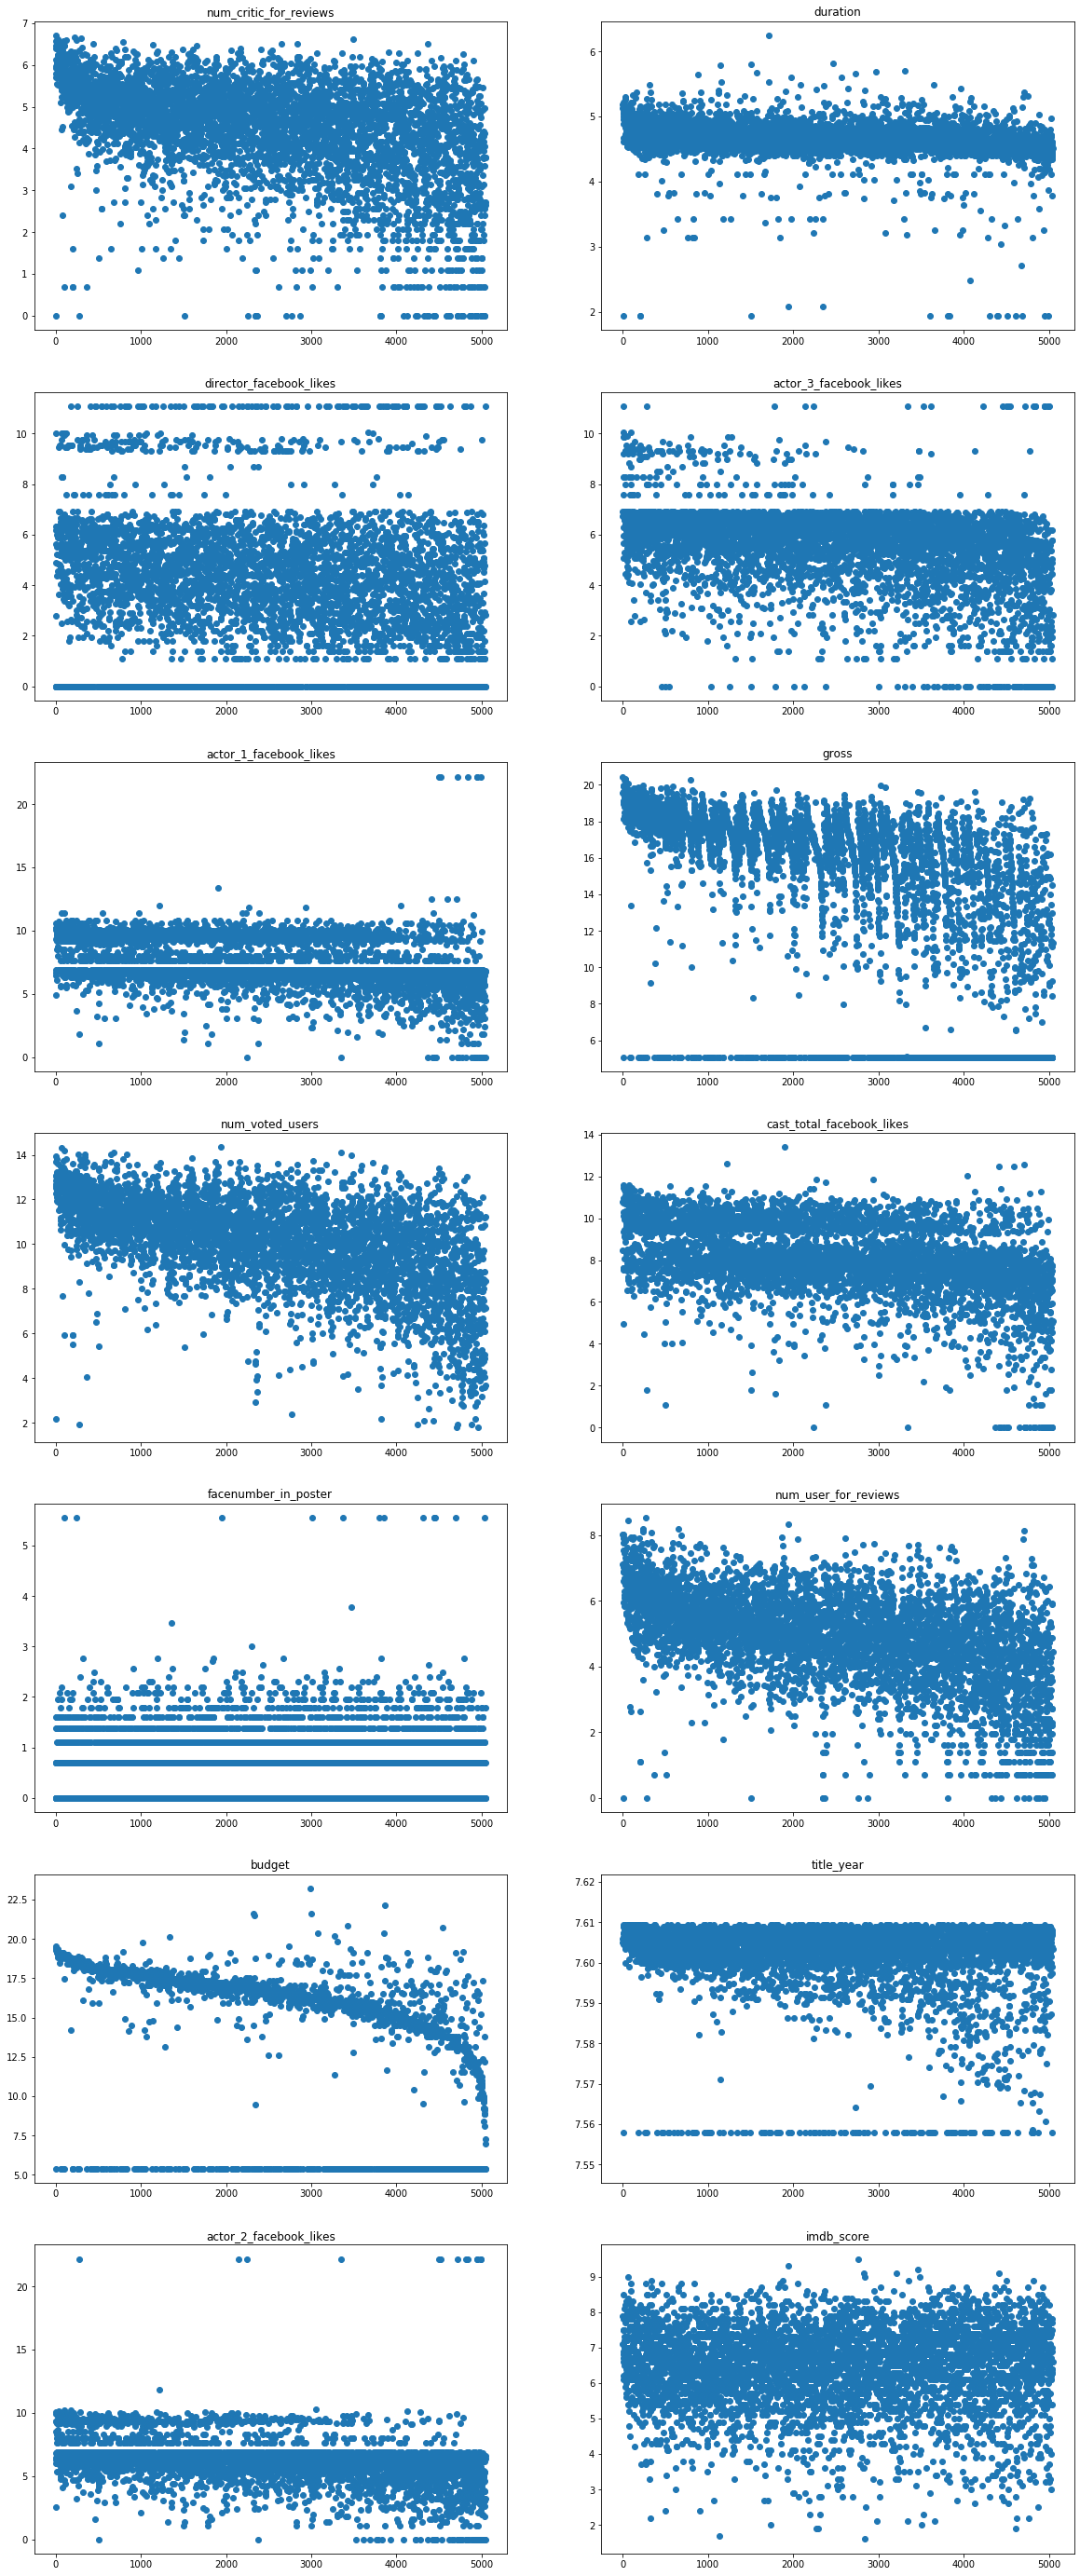

In [30]:
fig, ax = plt.subplots(len(numeric_features)//2, 2, figsize = (20,50))
for i in range(len(ax)):
    for j in range(len(ax[0])):
        #print(i, j, 2*i+j)
        ax[i][j].scatter(range(dataset_shape[0]), movie_metadata[numeric_features[2*i+j]])
        ax[i][j].title.set_text(numeric_features[2*i+j])

In [31]:
movie_metadata[categorical_features].nunique()

color                  2
director_name       2399
actor_2_name        3033
genres               914
actor_1_name        2098
movie_title         4917
actor_3_name        3522
language              48
country               66
content_rating        19
cleaned_language      13
cleaned_country       12
dtype: int64

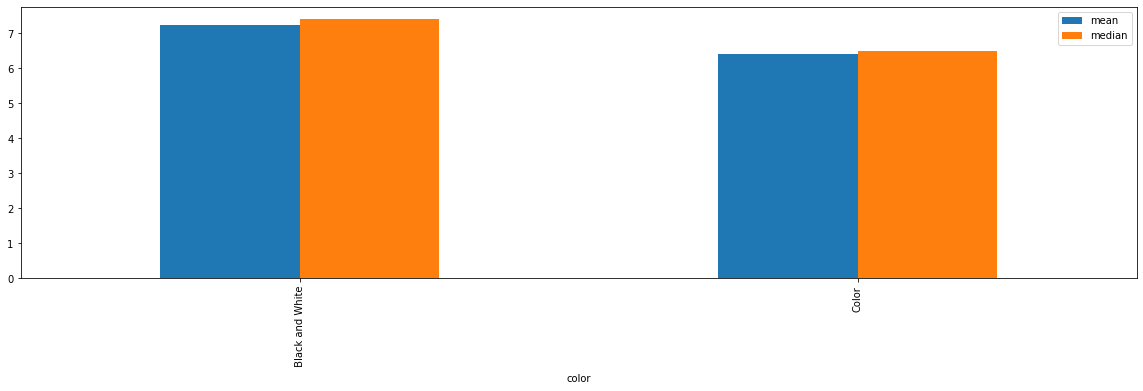

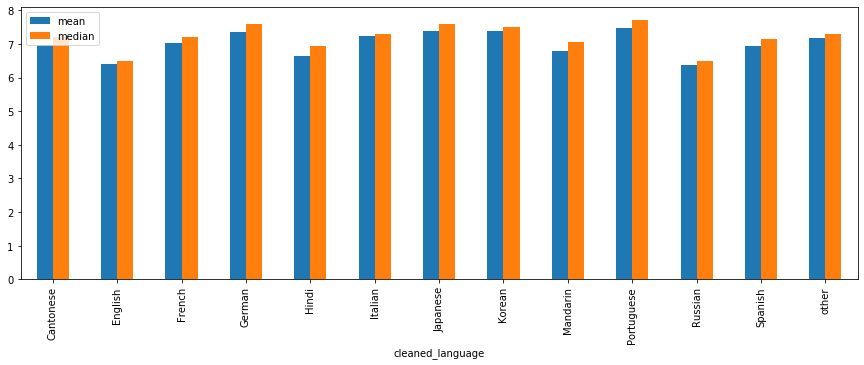

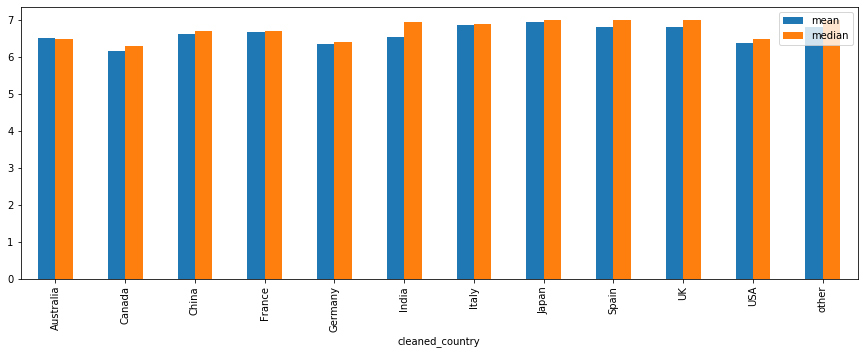

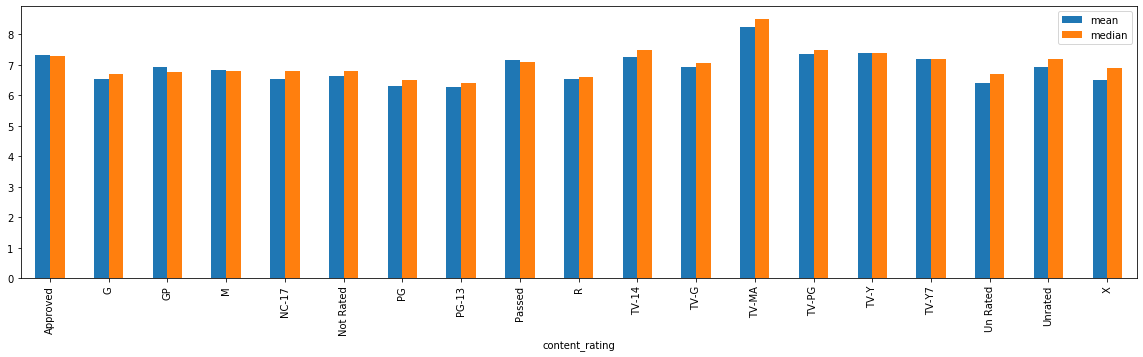

In [32]:
movie_metadata.groupby('color')['imdb_score'].agg(['mean', 'median']).plot(kind = 'bar', figsize = (20,5))
movie_metadata.groupby('cleaned_language')['imdb_score'].agg(['mean', 'median']).plot(kind = 'bar', figsize = (15,5))
movie_metadata.groupby('cleaned_country')['imdb_score'].agg(['mean', 'median']).plot(kind = 'bar', figsize = (15,5))
movie_metadata.groupby('content_rating')['imdb_score'].agg(['mean', 'median']).plot(kind = 'bar', figsize = (20,5))

In [33]:
movie_metadata_stats = movie_metadata.describe().T
movie_metadata_stats['IQR'] = movie_metadata_stats['75%'] - movie_metadata_stats['25%']
movie_metadata_stats

,count,mean,std,min,25%,50%,75%,max,IQR
num_critic_for_reviews,5043.0,4.449646,1.195786,0.000000,3.891820,4.700480,5.273000,6.701961,1.381180
duration,5043.0,4.649621,0.280572,1.945910,4.543295,4.644391,4.779123,6.238325,0.235828
director_facebook_likes,5043.0,3.823093,2.603168,0.000000,2.079442,3.970292,5.389072,11.090355,3.309630
actor_3_facebook_likes,5043.0,5.544543,1.581574,0.000000,4.908965,5.926926,6.459905,11.090355,1.550940
actor_1_facebook_likes,5043.0,7.434803,1.935849,0.000000,6.424058,6.897705,9.305741,22.180710,2.881683
gross,5043.0,14.403931,4.785835,5.087596,12.624067,16.542034,17.754313,20.449494,5.130246
num_voted_users,5043.0,10.097253,1.987013,1.791759,9.058878,10.444648,11.475327,14.340100,2.416450
cast_total_facebook_likes,5043.0,8.108973,1.734944,0.000000,7.252762,8.036250,9.529339,13.395030,2.276577
facenumber_in_poster,5043.0,0.642578,0.689941,0.000000,0.000000,0.693359,1.098633,5.546875,1.098633
num_user_for_reviews,5043.0,4.876921,1.375658,0.000000,4.174387,5.049856,5.783825,8.529320,1.609438


In [34]:
movie_metadata.drop(['director_name', 'actor_2_name', 'genres', 'actor_1_name', 
                         'movie_title', 'actor_3_name', 'language', 'country'], axis=1, inplace = True)

In [35]:
categorical_features = movie_metadata.columns[movie_metadata.dtypes=='object']
numeric_features, categorical_features

(Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
        'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
        'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
        'num_user_for_reviews', 'budget', 'title_year',
        'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes'],
       dtype='object'),
 Index(['color', 'content_rating', 'cleaned_language', 'cleaned_country'], dtype='object'))

In [36]:
train_movie_data = pd.get_dummies(movie_metadata, columns = categorical_features)

In [37]:
train_movie_data.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western', 'color_ Black and White', 'color_Color',
       'content_rating_Approved', 'content_rating_G', 'content_rating_GP',
       'content_rating_M', 'content_rating_NC-17', 'content_rating_Not Rated',
       'content_rating_PG', 'content_rating_PG-13', 'content_rating_Passed',
       'content_rating_R', 'content_rating_TV-14', 'content_rating

In [38]:
categorical_features = [feature for feature in train_movie_data.columns 
                        if feature not in numeric_features and feature!='imdb_score']
categorical_features

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western',
 'color_ Black and White',
 'color_Color',
 'content_rating_Approved',
 'content_rating_G',
 'content_rating_GP',
 'content_rating_M',
 'content_rating_NC-17',
 'content_rating_Not Rated',
 'content_rating_PG',
 'content_rating_PG-13',
 'content_rating_Passed',
 'content_rating_R',
 'content_rating_TV-14',
 'content_rating_TV-G',
 'content_rating_TV-MA',
 'content_rating_TV-PG',
 'content_rating_TV-Y',
 'content_rating_TV-Y7',
 'content_rating_Un Rated',
 'content_rating_Unrated',
 'content_rating_X',
 'cleaned_language_Cantonese',
 'cleaned_language_English',
 'cleaned_language_French',
 'cleaned_language_German',
 'cleaned_language_Hindi',
 'cleaned_language_Italian',
 'cleaned_lan

In [39]:
train_x, test_x, train_y, test_y = train_test_split(train_movie_data.drop('imdb_score', axis = 1), 
                                                    train_movie_data['imdb_score'], shuffle = True, test_size = 0.2)

In [40]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'r2', 'rmse', 'mae'},
            'subsample': 0.9,
            'learning_rate': 0.01,
            'feature_fraction': 0.6,
            'bagging_fraction': 0.7,
            'num_leaves': 512,
            'max_depth': 10,
            }

lgb_train = lgb.Dataset(train_x, train_y, categorical_feature = categorical_features)
lgb_eval = lgb.Dataset(test_x, test_y, categorical_feature = categorical_features)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=6000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=200,
               verbose_eval = 200)
    

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.579235	training's l1: 0.410051	valid_1's rmse: 0.767739	valid_1's l1: 0.546037
[400]	training's rmse: 0.441879	training's l1: 0.301616	valid_1's rmse: 0.713938	valid_1's l1: 0.498147
[600]	training's rmse: 0.378799	training's l1: 0.259491	valid_1's rmse: 0.705153	valid_1's l1: 0.489399
[800]	training's rmse: 0.338536	training's l1: 0.233499	valid_1's rmse: 0.700472	valid_1's l1: 0.486467
[1000]	training's rmse: 0.302837	training's l1: 0.209194	valid_1's rmse: 0.697416	valid_1's l1: 0.484366
[1200]	training's rmse: 0.276792	training's l1: 0.192009	valid_1's rmse: 0.694965	valid_1's l1: 0.482938
[1400]	training's rmse: 0.254232	training's l1: 0.176867	valid_1's rmse: 0.693264	valid_1's l1: 0.481849
[1600]	training's rmse: 0.235471	training's l1: 0.164233	valid_1's rmse: 0.691842	valid_1's l1: 0.480723
[1800]	training's rmse: 0.217378	training's l1: 0.151632	valid_1's rmse: 0.690937	valid_1's l1: 0.4801

In [41]:
print("Train Score : ", r2_score(gbm.predict(train_x), train_y), explained_variance_score(gbm.predict(train_x), train_y))
print("Test Score : ", r2_score(gbm.predict(test_x), test_y), explained_variance_score(gbm.predict(test_x), test_y))

Train Score :  0.9755794133409389 0.9755794133409389
Test Score :  0.43202665976755716 0.4330242516454036


In [42]:
et = ExtraTreesRegressor(bootstrap = True, max_depth = 16, max_leaf_nodes = 2048, random_state = 3, 
                         verbose = 1, oob_score = 'r2', criterion = 'mse')
et.fit(train_x, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished


ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                    max_depth=16, max_features='auto', max_leaf_nodes=2048,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score='r2',
                    random_state=3, verbose=1, warm_start=False)

In [43]:
print("R2 Score : ", r2_score(et.predict(test_x), test_y), explained_variance_score(et.predict(test_x), test_y))
et.score(train_x, train_y), et.score(test_x, test_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


R2 Score :  0.15818780754386585 0.15818907105367286


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


(0.8903317836209362, 0.6004459297468459)

In [44]:
rf = RandomForestRegressor(max_depth = 16, max_features = None, max_leaf_nodes = 512, random_state = 3, 
                           verbose = 1, n_estimators = 100, oob_score = 'r2')
rf.fit(train_x, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.6s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features=None, max_leaf_nodes=512,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score='r2',
                      random_state=3, verbose=1, warm_start=False)

In [45]:
print("R2 Score : ", r2_score(rf.predict(test_x), test_y), explained_variance_score(rf.predict(test_x), test_y))
rf.score(train_x, train_y), rf.score(test_x, test_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


R2 Score :  0.17729319858619674 0.17762713613585557


(0.9010667716939657, 0.5906641159355898)

In [46]:
gbr = GradientBoostingRegressor(learning_rate = 0.1, loss = 'huber', max_depth = 10, max_leaf_nodes = 512, 
                                random_state = 3, verbose = 1, n_estimators = 200, subsample = 0.8, 
                                n_iter_no_change = 5, validation_fraction = 0.2, tol = 1e-5)
gbr.fit(train_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5134           0.0481           17.67s
         2           0.4440           0.0537           19.55s
         3           0.3814           0.0418           18.99s
         4           0.3433           0.0333           18.86s
         5           0.2900           0.0292           18.90s
         6           0.2613           0.0238           19.06s
         7           0.2312           0.0195           18.59s
         8           0.2053           0.0151           18.41s
         9           0.1860           0.0122           17.89s
        10           0.1725           0.0103           17.53s
        20           0.0694           0.0029           15.81s
        30           0.0369          -0.0001           14.11s
        40           0.0192           0.0003           12.68s
        50           0.0128           0.0001           11.21s
        60           0.0083           0.0001           10.13s
       

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=10, max_features=None, max_leaf_nodes=512,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=5, presort='deprecated',
                          random_state=3, subsample=0.8, tol=1e-05,
                          validation_fraction=0.2, verbose=1, warm_start=False)

In [47]:
print("R2 Score : ", r2_score(gbr.predict(test_x), test_y), explained_variance_score(gbr.predict(test_x), test_y))
gbr.score(train_x, train_y), gbr.score(test_x, test_y)

R2 Score :  0.3056015814031027 0.30629946868178737


(0.9125537030586367, 0.6024093226143743)

In [48]:
hgbr = HistGradientBoostingRegressor(max_depth = 10, max_leaf_nodes = 512, scoring = ['r2', 'explained_variance_score'], 
                                     l2_regularization = 0.1, random_state = 3, verbose = 2, validation_fraction = 0.3, 
                                    max_iter = 50)
hgbr.fit(train_x, train_y)

Binning 0.003 GB of training data: 0.018 s
Fitting gradient boosted rounds:
[1/50] 1 tree, 116 leaves, max depth = 10, in 0.124s
[2/50] 1 tree, 121 leaves, max depth = 10, in 0.121s
[3/50] 1 tree, 122 leaves, max depth = 10, in 0.132s
[4/50] 1 tree, 125 leaves, max depth = 10, in 0.157s
[5/50] 1 tree, 105 leaves, max depth = 10, in 0.109s
[6/50] 1 tree, 119 leaves, max depth = 10, in 0.124s
[7/50] 1 tree, 119 leaves, max depth = 10, in 0.126s
[8/50] 1 tree, 111 leaves, max depth = 10, in 0.113s
[9/50] 1 tree, 128 leaves, max depth = 10, in 0.137s
[10/50] 1 tree, 117 leaves, max depth = 10, in 0.173s
[11/50] 1 tree, 100 leaves, max depth = 10, in 0.100s
[12/50] 1 tree, 128 leaves, max depth = 10, in 0.132s
[13/50] 1 tree, 119 leaves, max depth = 10, in 0.122s
[14/50] 1 tree, 108 leaves, max depth = 10, in 0.109s
[15/50] 1 tree, 133 leaves, max depth = 10, in 0.140s
[16/50] 1 tree, 128 leaves, max depth = 10, in 0.187s
[17/50] 1 tree, 119 leaves, max depth = 10, in 0.122s
[18/50] 1 tree,

HistGradientBoostingRegressor(l2_regularization=0.1, learning_rate=0.1,
                              loss='least_squares', max_bins=255, max_depth=10,
                              max_iter=50, max_leaf_nodes=512,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=3,
                              scoring=['r2', 'explained_variance_score'],
                              tol=1e-07, validation_fraction=0.3, verbose=2,
                              warm_start=False)

In [49]:
print("R2 Score : ", r2_score(hgbr.predict(test_x), test_y), explained_variance_score(hgbr.predict(test_x), test_y))
hgbr.score(train_x, train_y), hgbr.score(test_x, test_y)

R2 Score :  0.32150634646271425 0.3225653723718821


(0.867533541411739, 0.6181030719407172)